In [1]:
#Thesis for this strategy: Whenever there is significant price movement without the expected increase in volume...
##...the market was not efficient in the move and mean reversion is likely.

#Strategy flow: Conditioned on trend of long MA; Enter long position whenever price delta / volume delta surpasses defined 
#significance level... 
##...set equal TP and SL targets.

In [2]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

In [3]:
#Variable Hub
file = r"C:\Users\roger\PycharmProjects\algotrading\self_data\btcusd.csv"
#Expected Columns:
#time  open  close  high  low  volume
time_scale = 60
ma = 1000
volume_ma = 10
price_volume_dt_ratio = 8
ratio_ma_val = 50
sl_delta = .04
tp_delta = .04

In [4]:
#getting data from csv
granulated_data = {}
granulated_df = pd.read_csv(file)
granulated_data['time'] = [datetime.fromtimestamp(x/1000) for x in granulated_df['time']]
granulated_data['high'] = [x for x in granulated_df['high']]
granulated_data['low'] = [x for x in granulated_df['low']]
granulated_data['open'] = [x for x in granulated_df['open']]

In [5]:
#Function assumes data is in minutes and returns dict with user defined scale
def return_df(file, time_scale):
    original_data = pd.read_csv(file)
    new_data = {}
    new_data['time'] = [datetime.fromtimestamp(x/1000) for x in original_data['time'][::time_scale]]
    new_data['open'] = [x for x in original_data['open'][::time_scale]]
    new_data['volume'] = []
    new_data['volume_ma'] = []
    new_data['high'] = []
    new_data['low'] = []
    for i, volume in enumerate(original_data['volume'][::time_scale]):
        index = i * time_scale
        if i == 0:
            new_data['volume'].append(volume)
        else:
            new_data['volume'].append(sum(original_data['volume'][index-time_scale+1:index]))
    for i, vol in enumerate(new_data['volume']):
        if i <= volume_ma:
            new_data['volume_ma'].append(None)
        else:
            moving_average = sum(new_data['volume'][i-volume_ma-1:i]) / len(new_data['volume'][i-volume_ma-1:i])
            new_data['volume_ma'].append(moving_average)
    for i, high in enumerate(original_data['high'][::time_scale]):
        index = i * time_scale
        if i == 0:
            new_data['high'].append(high)
        else:
            new_data['high'].append(max(original_data['high'][index-time_scale+1:index]))
    for i, high in enumerate(original_data['low'][::time_scale]):
        index = i * time_scale
        if i == 0:
            new_data['low'].append(high)
        else:
            new_data['low'].append(min(original_data['low'][index-time_scale+1:index]))
    return new_data

#Function takes in dictionary and turns it out with another key list for the ma at that position and a second added key list for the marginal ma
def add_ma(dict, ma):
    dict['ma'] = []
    dict['ma_change'] = []
    for i, price in enumerate(dict['open']):
        if i <= ma:
            dict['ma'].append(None)
            dict['ma_change'].append(None)
        else:
            moving_average = sum(dict['open'][i-ma-1:i]) / len(dict['open'][i-ma-1:i])
            dict['ma'].append(moving_average)
            if not dict['ma'][i-1]:
                dict['ma_change'].append(None)
            elif dict['ma'][i] > dict['ma'][i-1]:
                dict['ma_change'].append(1)
            elif dict['ma'][i] < dict['ma'][i-1]:
                dict['ma_change'].append(-1)
            else:
                dict['ma_change'].append(0)
    return dict

In [6]:
new_data = return_df(file, time_scale)
new_data = add_ma(new_data, ma)
new_data['trade_journal'] = {}
new_data['trade_journal']['long'] = [[],[]]
new_data['trade_journal']['long_tp'] = [[],[]]
new_data['trade_journal']['long_sl'] = [[],[]]
new_data['trade_journal']['short'] = [[],[]]
new_data['trade_journal']['short_tp'] = [[],[]]
new_data['trade_journal']['short_sl'] = [[],[]]
new_data['trade_journal']['outcome'] = []
pricel = []
volumel = []
ratiol = []
volume_entry = []

In [7]:
#Determining when volume vs price movement conditions allow entry
for i in range(volume_ma+1):
    volume_entry.append(None)
for i in range(ratio_ma_val+1):
    volume_entry.append(None)  
for i, price in enumerate(new_data['open'][volume_ma+1:-1]):
        if new_data['volume'][i] and new_data['volume_ma'][i]:
            previous_price = new_data['open'][i-1]
            price_delta = abs(float(price) - float(previous_price)) / float(previous_price)
            volume_delta = float(new_data['volume'][i]) / float(new_data['volume_ma'][i])
            if len(ratiol) >= ratio_ma_val+1:
                ratio_ma = sum(ratiol[ratio_ma_val:]) / len(ratiol[ratio_ma_val:])
                if ((price_delta / volume_delta) / price_volume_dt_ratio) > ratio_ma:
                    volume_entry.append(price)
                else:
                    volume_entry.append(None)
            ratiol.append(price_delta / volume_delta)
            pricel.append(price_delta)
            volumel.append(volume_delta)
        else:
            volume_entry.append(None)
volume_entry.append(None)
new_data['volume_entries'] = volume_entry
volume_long_entry = []
volume_short_entry = []
in_trade = False
for i, time in enumerate(new_data['time']):
    if not new_data['volume_entries'][i]:
        volume_long_entry.append(None)
        volume_short_entry.append(None)
    elif (new_data['open'][i] < new_data['open'][i-1]):
        volume_long_entry.append(new_data['volume_entries'][i])
        volume_short_entry.append(None)
    elif (new_data['open'][i] > new_data['open'][i-1]):
        volume_short_entry.append(new_data['volume_entries'][i])
        volume_long_entry.append(None)
    else:
        volume_long_entry.append(None)
        volume_short_entry.append(None)

In [8]:
#Iterating through entries to calculate outcomes
outcome_list = []
for i, buy in enumerate(volume_long_entry):
    if buy:
        buy_time = new_data['time'][i]
        for inte, orig_time in enumerate(granulated_data['time']):
            if orig_time == buy_time:
                index_start = inte + 1
                break
        for position in range(index_start, len(granulated_data['time'])):
            low = granulated_data['low'][position]
            high = granulated_data['high'][position]
            delta_high = (float(high) - float(buy)) / float(buy)
            delta_low = (float(low) - float(buy)) / float(buy)
            if delta_high >= tp_delta:
                outcome_list.append(delta_high)
#                 print('Winner ' + str(granulated_data['time'][position]))
#                 print(delta_high)
#                 print('\n')
                break
            if delta_low <= sl_delta:
                outcome_list.append(delta_low)
#                 print(delta_low)
#                 print('Loser ' + str(granulated_data['time'][position]))
#                 print('\n')
                break

In [9]:
#removing edge case outlier
del outcome_list[0]
best = max(outcome_list)
worst = min(outcome_list)
mean = np.mean(outcome_list)
print('Highest HPR:', best)
print('Worst Drawdown:', worst)
print('Mean:', mean)

Highest HPR: 0.13037890082772102
Worst Drawdown: -0.03807950482005809
Mean: -0.0005015194623144925


In [10]:
#Performed extremely poorly (with current params)
#Problem is that the run time for one set of params is lengthy, so it is difficult to create a grid

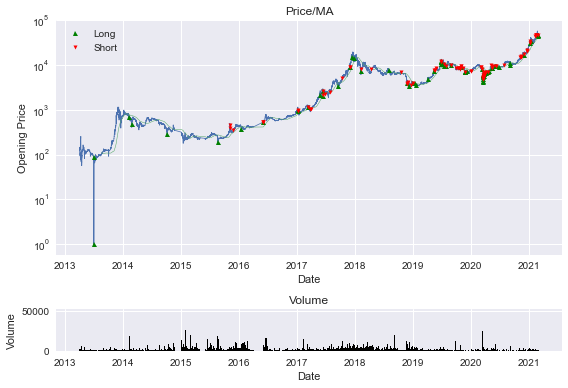

In [11]:
plt.style.use('seaborn')
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(new_data['time'], new_data['open'], linestyle = 'solid', linewidth= .75)
top.plot(new_data['time'], new_data['ma'], linestyle = 'solid', linewidth= .5)
top.plot(new_data['time'], volume_long_entry, '^', label='Long', markersize=5, color='g')
top.plot(new_data['time'], volume_short_entry, 'v', label='Short', markersize=4, color='r')
top.plot()
plt.title('Price/MA')
plt.legend()
plt.ylabel('Opening Price')
plt.xlabel('Date')
plt.yscale('log')

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(new_data['time'], new_data['volume'], color='k')
plt.title('Volume')
plt.ylabel('Volume')
plt.xlabel('Date')

plt.tight_layout()
plt.show()
